### <h2 style="font-size: 40px;">Прогноз цены автомобилей с пробегом</h2>

#### Техническое задание

Разработать модель машинного обучения для определения рыночной стоимости подержанных автомобилей на основе их технических характеристик и комплектаций. Модель будет использоваться в мобильном или веб-приложении, помогающем пользователям оценить стоимость своего автомобиля.


1. Ключевые требования:
    - Точность предсказаний – модель должна максимально точно предсказывать рыночную цену.
    - Скорость обучения – время обучения модели не должно быть чрезмерно большим.
    - Скорость предсказания – модель должна быстро выдавать результат, чтобы обеспечить удобство пользователей.


2. Данные:
    - Входные данные включают информацию о характеристиках автомобилей и их исторические цены.


3. Цель:
    - Построить модель, оптимально балансирующую между точностью и производительностью для интеграции в сервис оценки автомобилей.

#### Описание данных

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `Price` — цена (евро)

### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import warnings
import optuna
import phik

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error as MSE, r2_score

from optuna.integration import OptunaSearchCV
from sklearn.model_selection import GridSearchCV
from optuna.distributions import (
    CategoricalDistribution,
    IntDistribution,
    FloatDistribution
)

from tqdm.auto import tqdm
from functools import partial

RANDOM_STATE = 42


warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.CRITICAL)


In [2]:
# Функция для загрузки датасета 
def get_dataframe(path_global, path_local, dates_cols, sep=','):
    if os.path.exists(path_global):
        path = path_global
    elif os.path.exists(path_local):
        path = path_local
    else:
        print('Неправильный путь к файлу')
        return None
    
    df = pd.read_csv(path, sep=sep, parse_dates=dates_cols)
    display(df.head())

    print('Количество пропусков:')
    display(round(df.isna().mean() * 100, 2).sort_values(ascending=False))

    df.info()
    return df

In [3]:
path0 = '/datasets/autos.csv'
path1 = './datasets/autos.csv'
dates_cols = ['DateCrawled', 'DateCreated', 'LastSeen']

data_auto = get_dataframe(path0, path1, dates_cols)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Количество пропусков:


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xe. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

Repaired             20.08
VehicleType          10.58
FuelType              9.28
Gearbox               5.60
Model                 5.56
DateCrawled           0.00
Price                 0.00
RegistrationYear      0.00
Power                 0.00
Kilometer             0.00
RegistrationMonth     0.00
Brand                 0.00
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

#### Вывод загрузки данных

1. В таблице **`data_auto`** имеются пропуски:

| Признак          | % пропусков|
|------------------|------------|
| Repaired         | 20.08      |
| VehicleType      | 10.58      |
| FuelType         | 9.28       |
| Gearbox          | 5.60       |
| Model            | 5.56       |


2. Неправильные типы данных:

Следует обьединить `RegistrationYear` и `RegistrationMonth` в один признак под названием `RegistrationDate` и перевести в тип datetime64.

### Предобработка данных

#### Поиск дубликатов

In [4]:
display(data_auto[data_auto.duplicated(keep=False)])
data_auto = data_auto.drop_duplicates(keep='first').reset_index(drop=True)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


В датасете были обнаружены 4 полных дубликата, они были удалены.

#### Создание даты регистрации

In [5]:
data_auto['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

В данных присутсвтуют некорректные года регистрации пользователей.

In [6]:
data_auto['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

Нумерация месяца регистрации пользователя начинается с 0.

In [7]:
data_auto['RegistrationDate'] = pd.to_datetime(
    data_auto['RegistrationYear'].astype(str) + '-' + 
    (data_auto['RegistrationMonth'] + 1).astype(str) + '-01',  # +1 к месяцу
    format='%Y-%m-%d',
    errors='coerce'
)

data_auto.drop(['RegistrationMonth'], axis=1, inplace=True)
data_auto.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,RegistrationDate
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,1993-01-01
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,2011-06-01
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46,2004-09-01
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,2001-07-01
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,2008-08-01


В датасет была добавлена дата регистрации. Используя параметр *errors='coerce'* были упущены некорректные года регистрации.

In [8]:
data_auto.query('RegistrationDate < 2016 and RegistrationDate > 1980', inplace=True)

Данные по дате регистрации были ограничены периодом с 1980 по 2016 год.

#### Удаление и замена пропусков

In [9]:
for clm in data_auto.columns:
    if data_auto[clm].nunique() <= 25:
        print(f'{clm}: {data_auto[clm].unique()}')

VehicleType: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox: ['manual' 'auto' nan]
Kilometer: [150000 125000  90000  40000  30000  70000 100000  60000   5000  20000
  80000  50000  10000]
FuelType: ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
Repaired: [nan 'yes' 'no']
NumberOfPictures: [0]


Признак `NumberOfPictures` имеет значение значение 0 на всех наблюдениях. Такой признак является неиформативным и его следует удалить. \
В датасете отсутсвтуют неправильные значения признаков.

In [10]:
data_auto.drop('NumberOfPictures', axis=1, inplace=True)

data_auto.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,RegistrationDate
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57,1993-01-01
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,2011-06-01
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46,2004-09-01
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,2001-07-01
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,2008-08-01


Столбец `NumberOfPictures` был удален из датасета.

In [11]:
len_data = data_auto.shape[0]

data_auto.dropna(subset=['Model'], inplace=True)
print(f'Количество удаленных данных: {round(100 - data_auto.shape[0] / (len_data/100), 2)}%')

Количество удаленных данных: 4.79%


In [12]:
data_auto['VehicleType'] = (data_auto.groupby(['Brand', 'Model'])['VehicleType']
                            .transform(lambda x: x.fillna(x.mode()[0])))

Записи с пропусками колонки `Model` были удалены. Пропуски признака `VehicleType` восстановлены, используя моду по группам.

In [13]:
categorical_features = ['Repaired', 'FuelType', 'Gearbox']

cat_pipe = Pipeline(
    [
        ('simple_imputer_cat',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ]
)

In [14]:
preliminary_preprocessor = ColumnTransformer(
    [
        ('fill_na_cat', cat_pipe, categorical_features)
    ], 
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [15]:
lst_columns_train = data_auto.columns.tolist() # Порядок столбцов прошлой таблицы

data_auto = (preliminary_preprocessor.fit_transform(data_auto.drop('Price', axis=1))
                          .join(data_auto['Price']))[lst_columns_train]

#### Вывод предобработки данных

Было удалено 4 полных дубликата в данных. \
Номер месяца регистрации `RegistrationMonth` был удален после создания ограниченной даты регистрации периодом с 1980 по 2016 год. \
Неиформативный признак `NumberOfPictures`, содержащий нули на всем промежутке наблюдений, был удален. \
Записи с пропусками колонки `Model` были удалены. Пропуски признака `VehicleType` восстановлены, используя моду по группам. \
Пропуски признаков `Repaired`, `FuelType`, `Gearbox` были заменены на самые часто встречаемые значения категорий.

### Исследовательский анализ

#### Распределение признаков

In [16]:
def plt_distribution(df):
    plt.figure(figsize=(22, 18))
    cols_num = df.select_dtypes(include='number').columns
    cols_cat = data_auto.select_dtypes(exclude='number').columns

    i = 1
    # Отрисовка распределений количественных фич
    for clm in cols_num:
        plt.subplot(3, 3, i)
        if df[clm].nunique() >= 20:
            ax = sns.histplot(data=df, x=clm, stat="density")
            sns.kdeplot(data=df, x=clm, bw_method=0.07, color="red")
        else:
            ax = sns.countplot(data=df, x=clm, color='#1F77B4') 
        ax.set_ylabel('частота')
        i += 1

    # Графики категориальных
    for clm in cols_cat:
        if df[clm].nunique() <= 20:
            plt.subplot(3, 3, i)
            ax = sns.countplot(data=df, x=clm, color='#1F77B4')
            ax.set_ylabel('частота')
            i += 1

In [17]:
data_auto.describe()

,Price,RegistrationYear,Power,Kilometer,PostalCode
count,289102.000000,289102.000000,289102.000000,289102.000000,289102.000000
mean,4591.940720,2002.580916,112.907680,128528.979391,50916.975673
std,4566.415459,5.675358,173.319829,36990.959583,25773.137673
min,0.000000,1980.000000,0.000000,5000.000000,1067.000000
25%,1200.000000,1999.000000,75.000000,125000.000000,30625.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,49757.000000
75%,6650.000000,2007.000000,143.000000,150000.000000,71570.000000
max,20000.000000,2015.000000,20000.000000,150000.000000,99998.000000


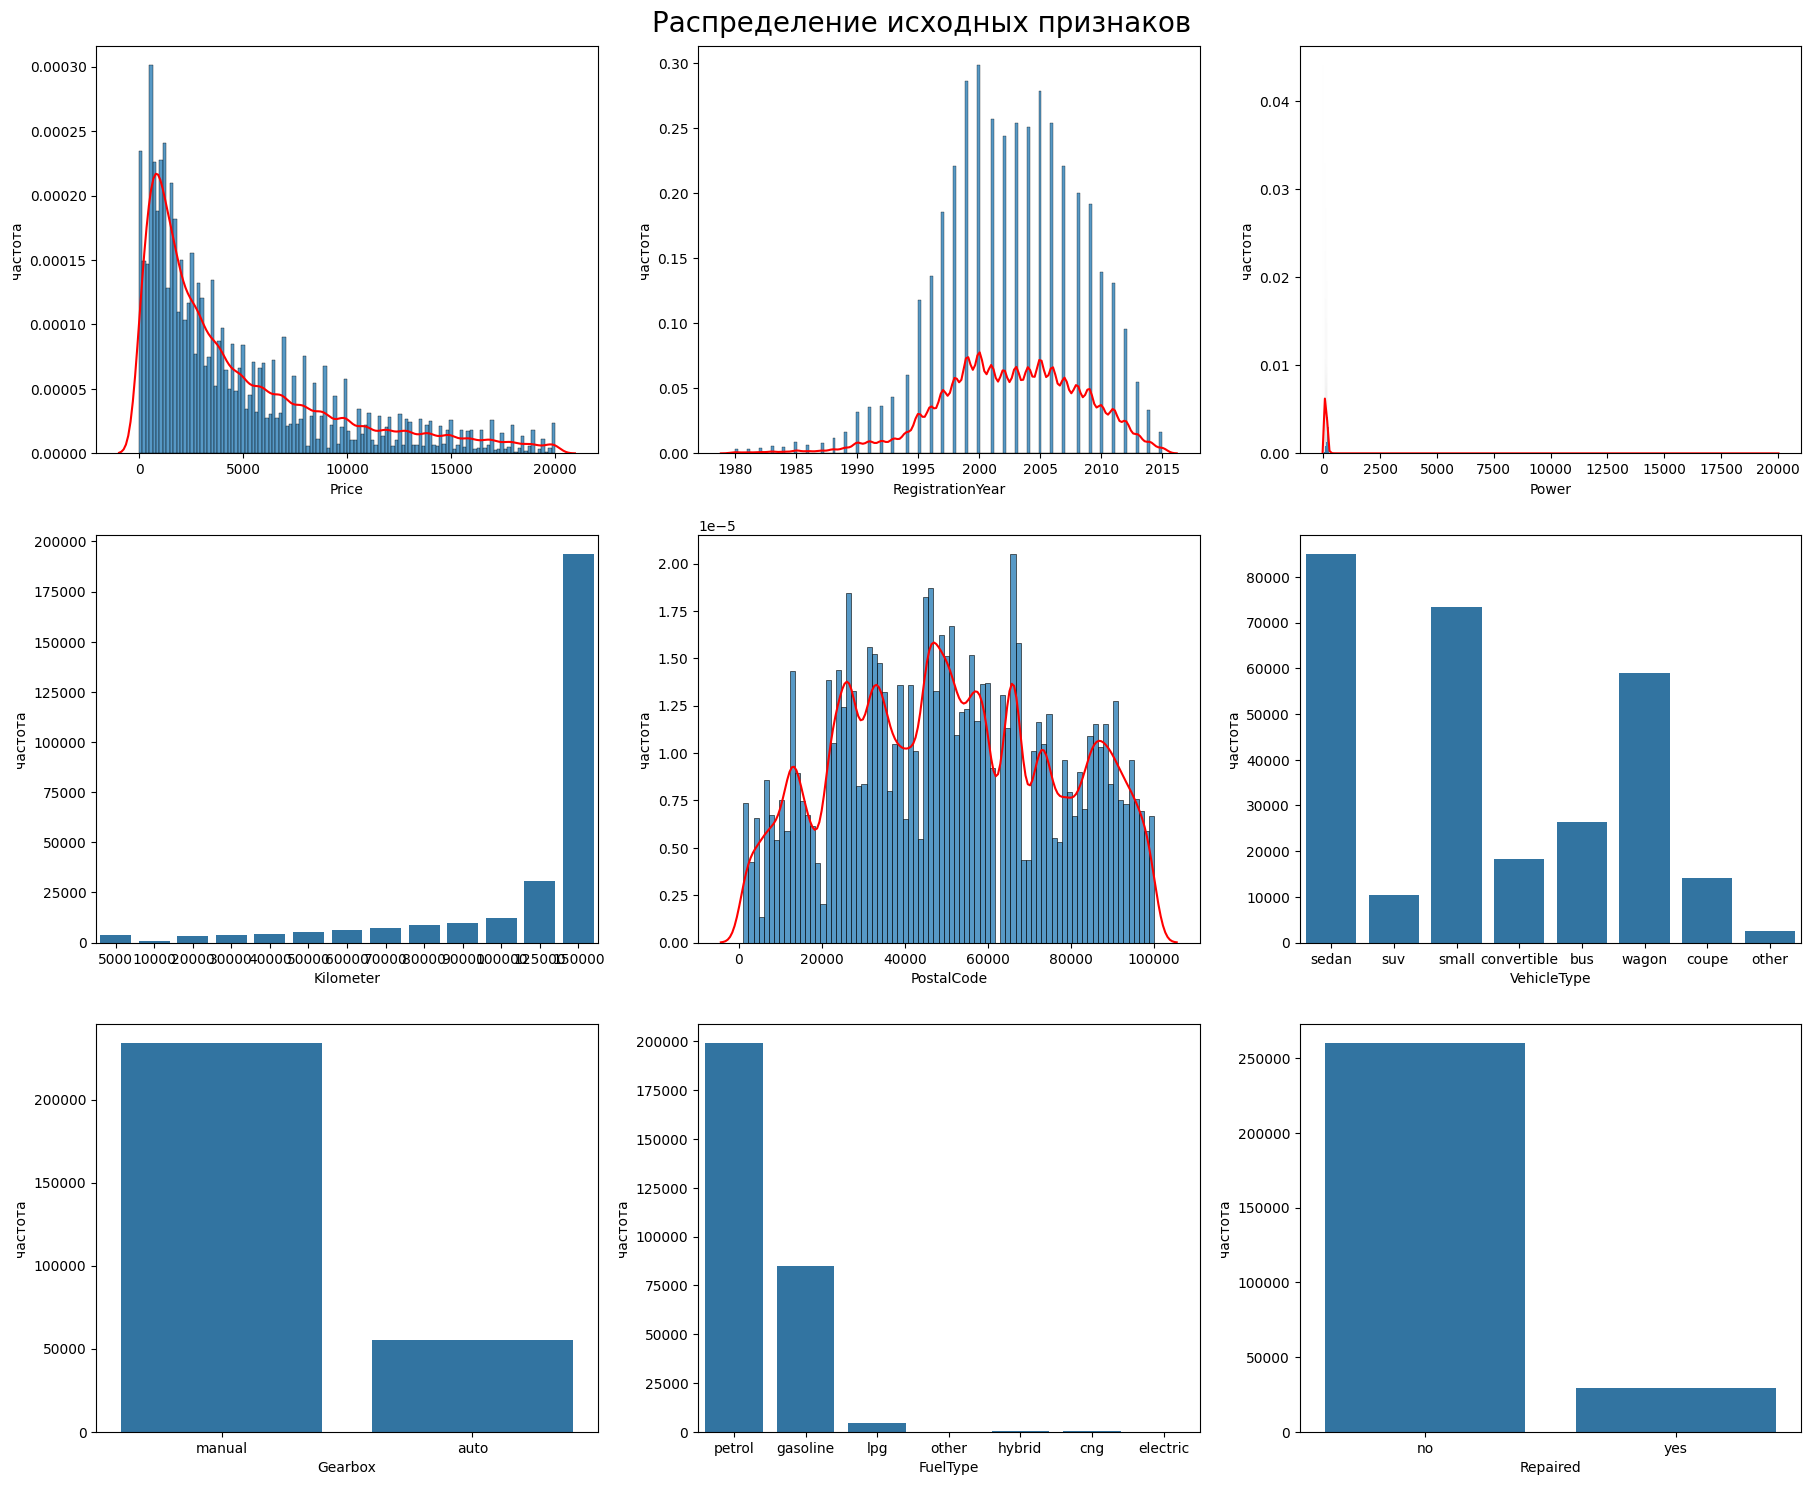

In [18]:
plt_distribution(data_auto)
plt.suptitle('Распределение исходных признаков', y=0.9, fontsize=20)

plt.show()

В данных наблюдаются аномалии и выбросы:
1. `Price` имеет нулевые значения
2. `Power` имеет и нулевые и экстремально большие значения
3. `FuelType` имеет малое количество наблюдений на категориях 'other', 'hybrid', 'cng', 'electric'

#### Удаление выбросов и аномалий

In [19]:
data_auto.query('Price > 100', inplace=True)

Нулевые значения стоимости были убраны фильтром. Остались наблюдения, у которых стоимость более 100.

In [20]:
data_auto.query('Power < 500 and Power > 50', inplace=True)

Мощность была ограничена отрезком от 50 до 500 лошадиных сил.

In [ ]:
data_auto['FuelType'] = np.where(
    data_auto['FuelType'].isin(['gasoline', 'petrol', 'lpg', 'other']), 
    data_auto['FuelType'], 
    'other'
)

Чтобы не удалять редкие категории, они были обьеденены в значение 'other'.

In [22]:
data_auto.reset_index(drop=True, inplace=True)

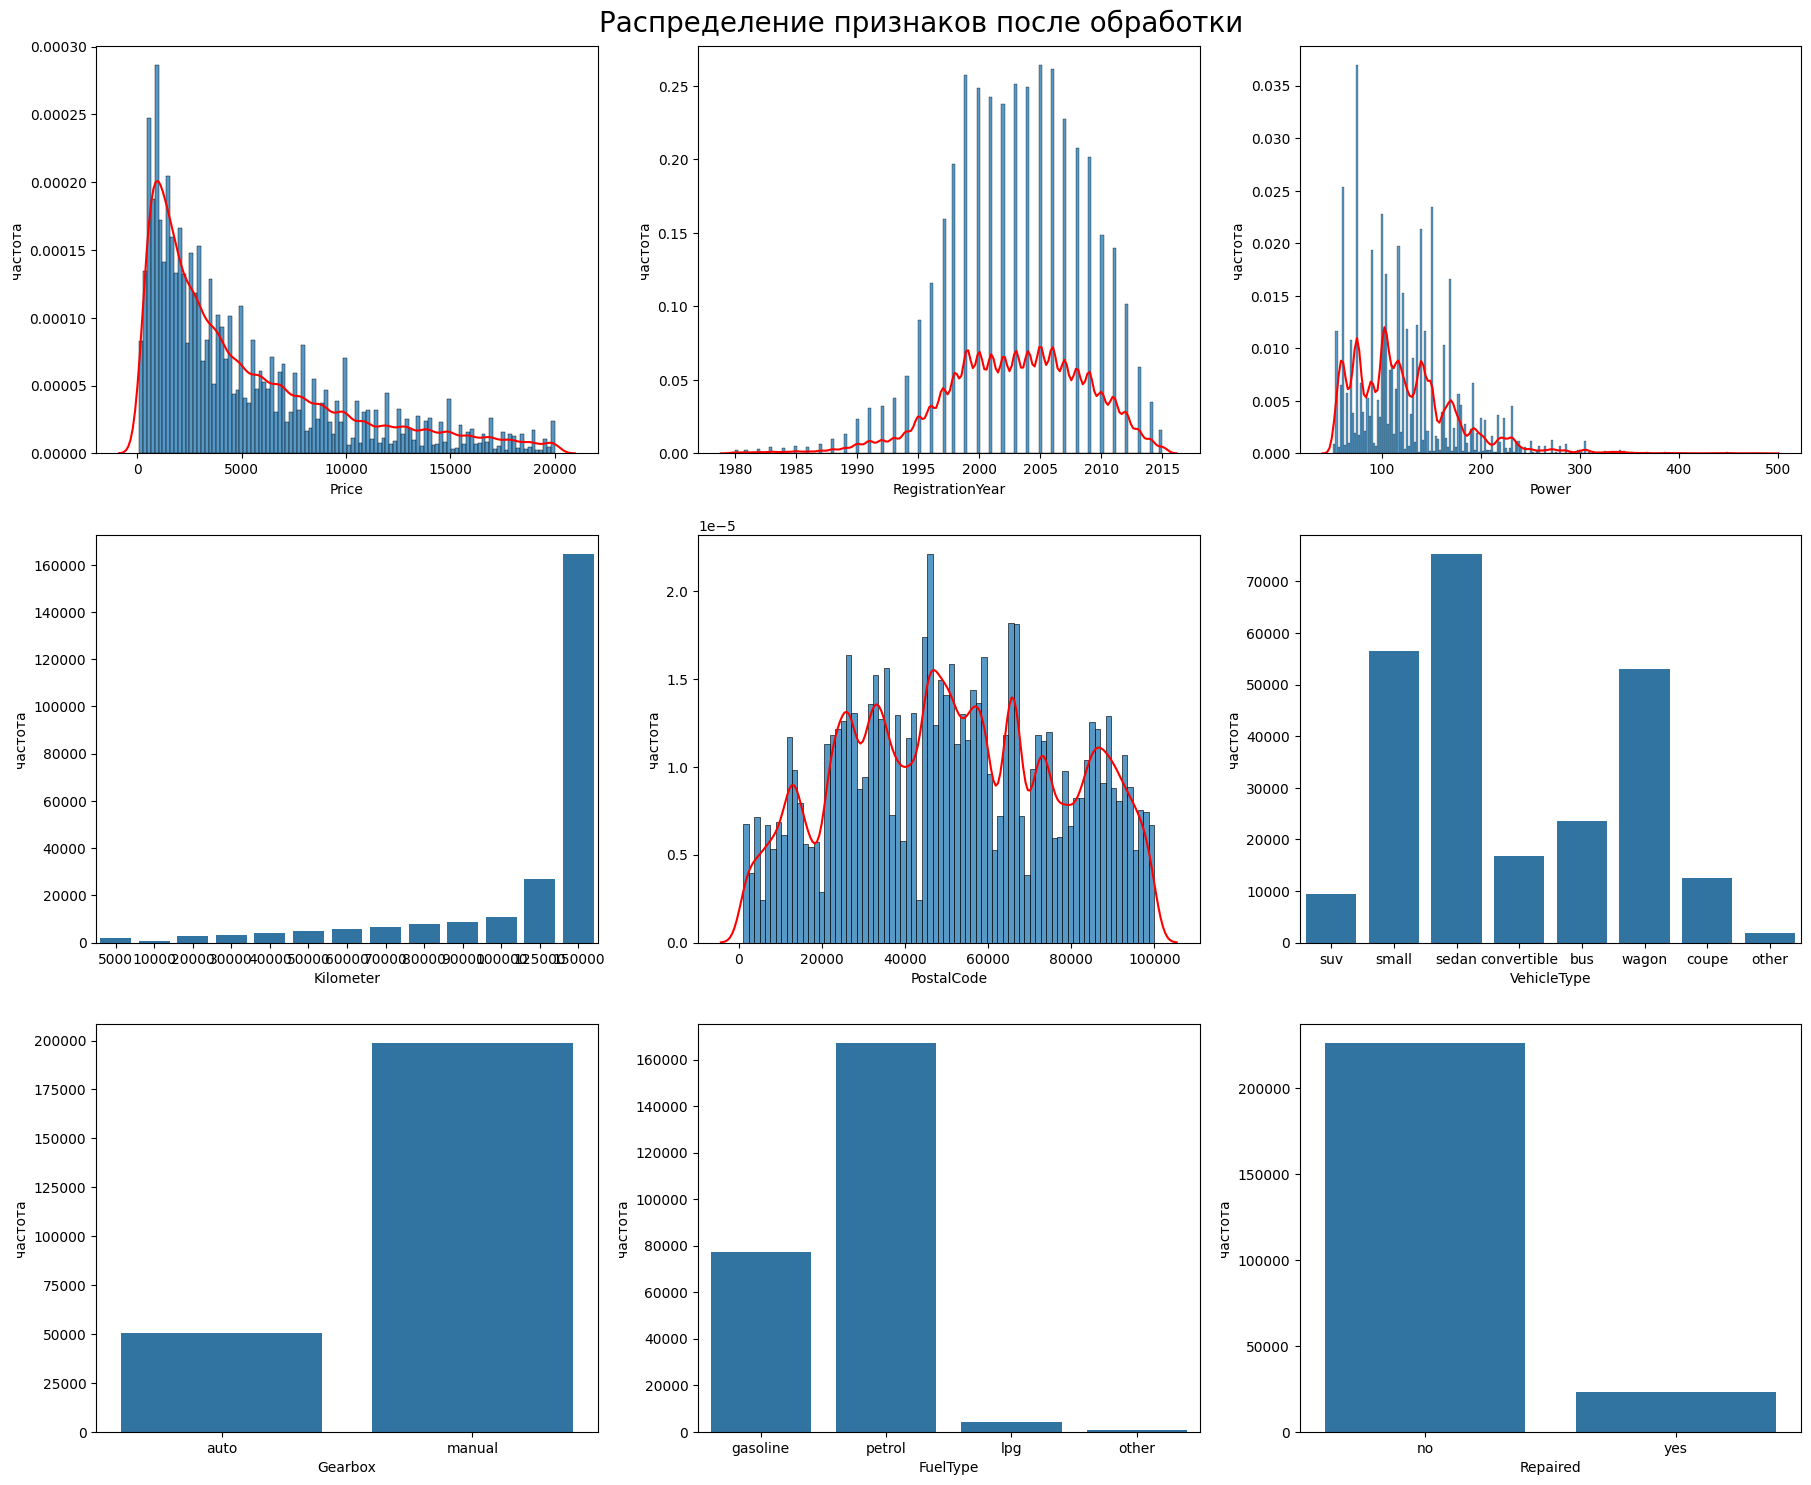

In [23]:
plt_distribution(data_auto)
plt.suptitle('Распределение признаков после обработки', y=0.9, fontsize=20)

plt.show()

#### Корреляицонный анализ

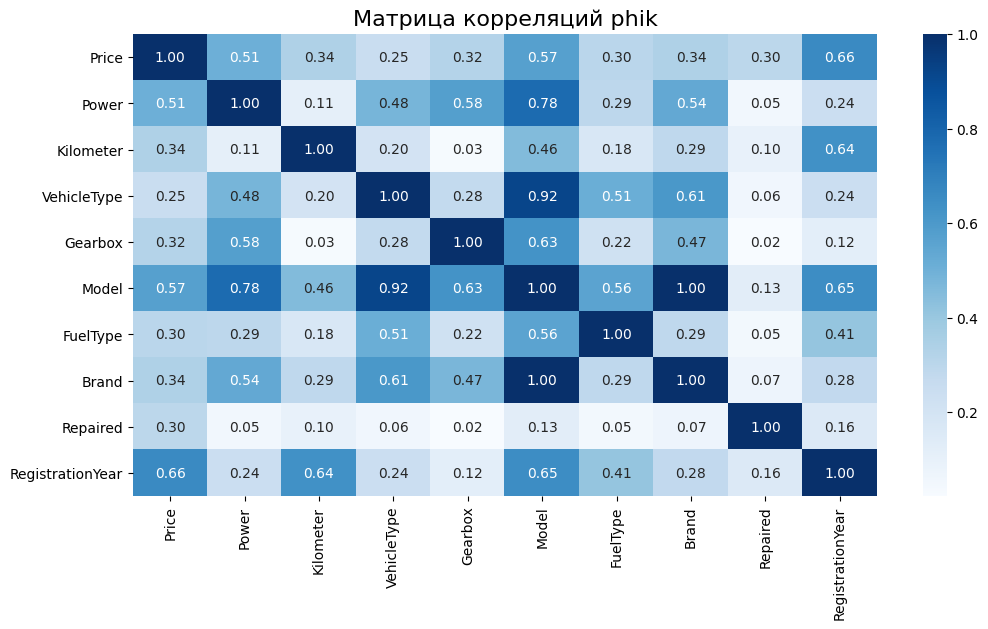

In [24]:
corr_lst = ['Price', 'Power', 'Kilometer', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'RegistrationYear']

plt.figure(figsize=(12, 6))

sns.heatmap(
        data_auto[corr_lst].phik_matrix(interval_cols=['Price', 'Power']),
        annot=True,
        fmt='.2f',
        cmap='Blues'
)

plt.title('Матрица корреляций phik', fontsize=16)
plt.show()

#### Вывод исследовательского анализа

Нулевые значения стоимости были убраны фильтром. \
Мощность была ограничена отрезком от 50 до 250 лошадиных сил. \
Редкие категории топлива были обьеденены в общую группу с значением 'other'. 

1. Связь с целевым:
    - `RegistrationYear` - 0.67
    - `Model` - 0.56
    - `Power` - 0.47
    - `Kilometer` - 0.35


2. Мультиколлинеарность:
    - `Power`: `Model` (0.81)
    - `VehicleType`: `Model` (0.92)
    - `Model`: `Brand` (1.00)

### Подготовка данных и обучение моделей

In [25]:
X = data_auto.drop(['DateCrawled', 'Price', 'DateCreated', 'PostalCode', 'Model', 'LastSeen', 'RegistrationDate'], axis=1)
y = data_auto['Price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=RANDOM_STATE,
                                                    test_size=0.25)

In [26]:
ohe_cols = ['VehicleType', 'Gearbox', 'FuelType', 'Brand']
ord_cols = ['Repaired']
num_cols = ['RegistrationYear', 'Power', 'Kilometer']

In [27]:
pipe_ohe = Pipeline([
    ('simpleImputer_ohe',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ('ohe',
    OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

pipe_ord = Pipeline([
    ('simpleImputer_before_ord',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value',
                           unknown_value=np.nan,
                            categories=[['no', 'yes']])),
    
    ('simpleImputer_after_ord',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [28]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', pipe_ohe, ohe_cols),
        ('ord', pipe_ord, ord_cols),
        ('scaled', MinMaxScaler(), num_cols)
    ],
    remainder='passthrough'
)


pipe_final = Pipeline([
    ('fillna', preliminary_preprocessor),
    ('preprocessor', data_preprocessor),
    ('models', CatBoostRegressor(verbose=0, random_state=RANDOM_STATE))
])

#### Линейная регрессия

In [29]:
param_grid = [{'models': [LinearRegression()],
               'models__copy_X': [True,False],
               'models__fit_intercept': [True,False], 
               'models__n_jobs': [*range(1, 15), None],
               'models__positive': [True,False]}]


grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1)

In [30]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fillna',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('fill_na_cat',
                                                                         Pipeline(steps=[('simple_imputer_cat',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['Repaired',
                                                                          'FuelType',
                                                                          'Gearbox'])],
                                                          verbose_feature_names_out=False)),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('...
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer'])])),
                                       ('models',
                                        <catboost.core.CatBoostRegressor object at 0x7c2862c7ffa0>)]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression()],
                          'models__copy_X': [True, False],
                          'models__fit_intercept': [True, False],
                          'models__n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                             12, 13, 14, None],
                          'models__positive': [True, False]}],
             scoring='neg_root_mean_squared_error')

In [31]:
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

X_train_scaled_lr = pd.DataFrame(data=preprocessor.transform(X_train), columns=preprocessor.get_feature_names_out())


print('Гиперпараметры лучшей модели LinearRegression:')
for k, v in grid_search.best_params_.items():
    if k != 'models':
        print(f"{k}: {v}")

Гиперпараметры лучшей модели LinearRegression:
models__copy_X: True
models__fit_intercept: True
models__n_jobs: 1
models__positive: False


In [32]:
%%time
model_lr = LinearRegression(copy_X=True,
                            fit_intercept=True,
                            n_jobs=1,
                            positive=False)

model_lr.fit(X_train_scaled_lr, y_train)

CPU times: user 667 ms, sys: 341 ms, total: 1.01 s
Wall time: 161 ms


LinearRegression(n_jobs=1)

Обучение модели линейной регрессии с заданными гиперпараметрами заняло +-180ms. \
Лучшая метрика *RMSE* на кросс-валидации: *2485*.

#### LGBMRegressor

In [33]:
# функция для прогресс-бара
def tqdm_callback_lr(study, trial, pbar):
    pbar.update(1)
    if study.best_trial.number == trial.number:
        pbar.set_postfix({"Лучшая метрика RMSE": f"{-trial.value:.4f}"})


# Функция для поиска наилучших гиперпараметров, используя Байесовскую оптимизацию
def optuna_search_lr(param_distributions, X, y, pipe, epoch=50):
    pbar = tqdm(total=epoch, desc="Поиск гиперпараметров Optuna")

    oscv = OptunaSearchCV(
        pipe,
        param_distributions,
        scoring='neg_root_mean_squared_error',
        cv=3,
        n_trials=epoch,
        random_state=RANDOM_STATE,
        callbacks=[partial(tqdm_callback_lr, pbar=pbar)]
    )

    oscv.fit(X, y)
    pbar.close()
    
    return oscv

In [34]:
param_distributions_lightgbm = {
    "models": CategoricalDistribution([
    LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)]),
    
    'models__n_estimators': IntDistribution(50, 1000),
    'models__learning_rate': FloatDistribution(0.01, 0.1, log=True),
    'models__num_leaves': IntDistribution(20, 150),
    'models__max_depth': IntDistribution(3, 20),
    'models__min_child_samples': IntDistribution(1, 20),
    'models__reg_alpha': FloatDistribution(0.0, 1.0),
    'models__reg_lambda': FloatDistribution(0.0, 1.0),
    'models__boosting_type': CategoricalDistribution(['gbdt', 'dart'])
}

oscv_lightgbm = optuna_search_lr(param_distributions_lightgbm, X, y, pipe_final)

Поиск гиперпараметров Optuna:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print('Гиперпараметры лучшей модели lightgbm:')
for k, v in oscv_lightgbm.best_params_.items():
    if k != 'models':
        print(f"{k}: {v}")

Гиперпараметры лучшей модели lightgbm:
models__n_estimators: 635
models__learning_rate: 0.09807746512621508
models__num_leaves: 128
models__max_depth: 19
models__min_child_samples: 8
models__reg_alpha: 0.7311088225235114
models__reg_lambda: 0.5532733610223152
models__boosting_type: gbdt


In [ ]:
%%time
model_lgbm = LGBMRegressor(
    boosting_type='gbdt',
    learning_rate=0.09807746512621508,
    max_depth=19,
    min_child_samples=8,
    n_estimators=635,
    num_leaves=128,
    reg_alpha=0.7311088225235114,
    reg_lambda=0.5532733610223152,
    verbose=-1,
    random_state=RANDOM_STATE
)

model_lgbm.fit(X_train_scaled_lr, y_train)

CPU times: user 6.9 s, sys: 76 ms, total: 6.98 s
Wall time: 1.19 s


LGBMRegressor(learning_rate=0.09807746512621508, max_depth=19,
              min_child_samples=8, n_estimators=635, num_leaves=128,
              random_state=42, reg_alpha=0.7311088225235114,
              reg_lambda=0.5532733610223152, verbose=-1)

Модель **LGBMRegressor** имеет лучший результат по сравнению с **LinearRegression**. \
Обучение модели **LGBMRegressor** с заданными гиперпараметрами заняло +-1.2s. \
Лучшая метрика *RMSE* на кросс-валидации: *1508*.

#### CatBoostRegressor

In [ ]:
param_distributions_catboost = {
    'models__n_estimators': IntDistribution(50, 1000),
    'models__learning_rate': FloatDistribution(0.01, 0.1, log=True),
    'models__depth': IntDistribution(5, 40),
    'models__l2_leaf_reg': IntDistribution(1, 10),
    'models__bagging_temperature': FloatDistribution(0, 1),
    'models__random_strength': FloatDistribution(0, 1),
    'models__border_count': IntDistribution(32, 255),
    'models__grow_policy': CategoricalDistribution(['SymmetricTree', 'Depthwise', 'Lossguide'])
}

oscv_catboost = optuna_search_lr(param_distributions_catboost, X, y, pipe_final)

Поиск гиперпараметров Optuna:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
print('Гиперпараметры лучшей модели CatBoost:')
for k, v in oscv_catboost.best_params_.items():
    if k != 'models':
        print(f"{k}: {v}")

Гиперпараметры лучшей модели CatBoost:
models__n_estimators: 521
models__learning_rate: 0.03443586421303639
models__depth: 12
models__l2_leaf_reg: 4
models__bagging_temperature: 0.7568975107185656
models__random_strength: 0.029082755595781773
models__border_count: 196
models__grow_policy: SymmetricTree


In [ ]:
%%time
model_catboost = CatBoostRegressor(
    iterations=521,
    learning_rate=0.03443586421303639,
    depth=12,
    l2_leaf_reg=4,
    bagging_temperature=0.7568975107185656,
    random_strength=0.029082755595781773,
    border_count=196,
    grow_policy='SymmetricTree',
    verbose=0,
    random_state=RANDOM_STATE
)

model_catboost.fit(X_train_scaled_lr, y_train)

CPU times: user 37.3 s, sys: 30.3 s, total: 1min 7s
Wall time: 7.58 s


Модель **CatBoostRegressor** имеет меньшую метрику RMSE по сравнению с **LGBMRegressor** и большее время обучения на подобранных гиперпараметрах. \
Обучение модели **CatBoostRegressor** с заданными гиперпараметрами заняло +-7.5s. \
Лучшая метрика *RMSE* на кросс-валидации: *1573*.

#### XGBRegressor

In [ ]:
param_distributions_XGBR = {
    "models": CategoricalDistribution([
    XGBRegressor(verbosity=0, random_state=RANDOM_STATE)]),

    'models__n_estimators': IntDistribution(50, 1000),
    'models__learning_rate': FloatDistribution(0.01, 0.1, log=True),
    'models__max_depth': IntDistribution(5, 40),
    'models__min_child_weight': IntDistribution(1, 15),
    'models__subsample': FloatDistribution(0.4, 1),
    'models__colsample_bytree': FloatDistribution(0.4, 1),
    'models__gamma': FloatDistribution(0.6, 1),
    'models__reg_alpha': FloatDistribution(0.01, 1),
    'models__reg_lambda': IntDistribution(1, 10)

}

oscv_XGBR = optuna_search_lr(param_distributions_XGBR, X, y, pipe_final)

Поиск гиперпараметров Optuna:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
print('Гиперпараметры лучшей модели xgboost:')
for k, v in oscv_XGBR.best_params_.items():
    if k != 'models':
        print(f"{k}: {v}")

Гиперпараметры лучшей модели xgboost:
models__n_estimators: 393
models__learning_rate: 0.02366205962399807
models__max_depth: 36
models__min_child_weight: 12
models__subsample: 0.5732881825853615
models__colsample_bytree: 0.9069226596827725
models__gamma: 0.8743696289486552
models__reg_alpha: 0.9489336368109251
models__reg_lambda: 10


In [ ]:
%%time
model_xgboost = XGBRegressor(
    n_estimators=393,
    learning_rate=0.02366205962399807,
    max_depth=36,
    min_child_weight=12,
    subsample=0.5732881825853615,
    colsample_bytree=0.9069226596827725,
    gamma=0.8743696289486552,
    reg_alpha=0.9489336368109251,
    reg_lambda=10,
    verbosity=0,
    random_state=RANDOM_STATE
)

model_xgboost.fit(X_train_scaled_lr, y_train)

CPU times: user 1min 16s, sys: 388 ms, total: 1min 16s
Wall time: 6.77 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9069226596827725, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.8743696289486552,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02366205962399807,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=36, max_leaves=None,
             min_child_weight=12, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=393, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Метрика модели **XGBRegressor** незначительно меньше **LGBMRegressor**. \
Обучение модели **XGBRegressor** с заданными гиперпараметрами заняло +-6.5s. \
Лучшая метрика *RMSE* на кросс-валидации: *1508*.

#### Выбор лучшей модели

Опираясь на критерии заказчика, была выбрана модель **LGBMRegressor**, она имеет меньшее время обучения и хорошую метрику RMSE. 

In [ ]:
# Графики остатков
def residuals_plot(y_pred, y_test):
    plt.figure(figsize=(14, 5))
    residuals = y_test - y_pred

    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True)
    plt.title('Гистограмма распределения остатков')
    plt.ylabel('остатки')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_pred, y=residuals)
    sns.regplot(x=y_pred, y=residuals, order=2)
    plt.title('Анализ дисперсии')
    plt.xlabel('предсказание')
    plt.ylabel('остатки')

    plt.show()

In [ ]:
X_test_scaled_lr = pd.DataFrame(data=preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

y_pred = model_lgbm.predict(X_test_scaled_lr)
print('RMSE:', round(MSE(y_test, y_pred)**0.5, 2))
print('R2:', round(r2_score(y_test, y_pred), 3))

RMSE: 1493.32
R2: 0.896


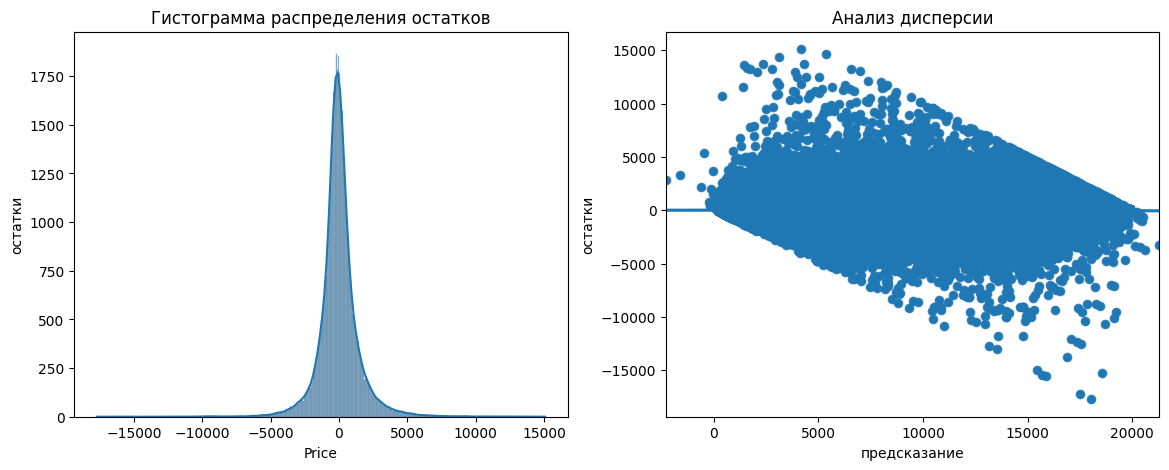

In [ ]:
residuals_plot(y_pred, y_test)

Метрика RMSE на тестовых данных получилась меньше, чем при кросс-валидации. В 89.6% случаев предсказание модели ближе к истине, чем среднее значение целевого признака. Распределение остатков говорит о том, что модель не имеет систематического смещения, ошибки распределены равномерно.

In [ ]:
importances = model_lgbm.feature_importances_

feature_importance = pd.DataFrame({
    'feature': X_train_scaled_lr.columns,
    'importance': importances
}).sort_values(by='importance', ascending=True)

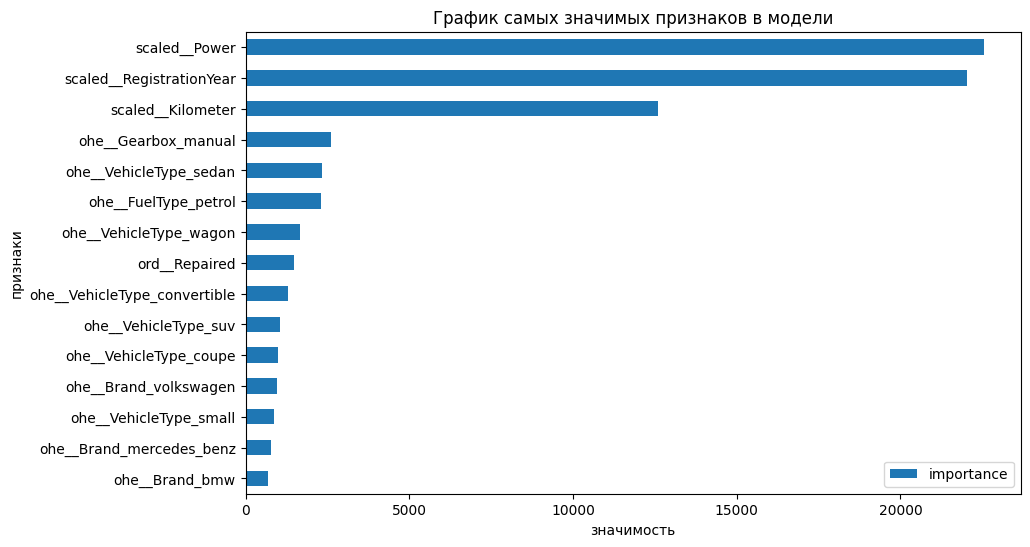

In [ ]:
feature_importance.tail(15).plot(x='feature', y='importance', kind='barh', figsize=(10, 6))

plt.title('График самых значимых признаков в модели')
plt.xlabel('значимость') 
plt.ylabel('признаки') 

plt.show()

Дата регистрации автомобиля, количество лошадинных сил и пробег имеют наибольшую значимость для предсказания модели.

### Общий вывод работы

1. Предобработка данных:
   - Удалены дубликаты и некорректные значения (например, нулевые цены, аномальные значения мощности и года регистрации).
   - Пропуски в категориальных признаках заполнены наиболее часто встречающимися значениями.
   - Редкие категории признака `FuelType` были объединены в группу `other`.
2. Исследовательский анализ:
   - Выявлены наиболее значимые признаки, влияющие на цену: `RegistrationYear`, `Power`, `Kilometer` и `Model`.
   - Обнаружена мультиколлинеарность между некоторыми признаками (например, `Model` и `Brand`), что было учтено при выборе финальных признаков для модели.
3. Обучение моделей:
   - Были протестированы четыре модели: **LinearRegression**, **LGBMRegressor**, **CatBoostRegressor** и **XGBRegressor**.
   - Для оптимизации гиперпараметров использовался метод *OptunaSearchCV*, что позволило улучшить качество моделей.
   - Наилучшие результаты показала модель **LGBMRegressor** с метрикой *RMSE = 1493.32* и *R² = 0.896* на тестовых данных.
4. Выбор модели:
   - Модель **LGBMRegressor** была выбрана как оптимальная, так как она сочетает высокую точность и приемлемое время обучения, что соответствует требованиям заказчика.
5. Анализ остатков:
   - Распределение остатков показало отсутствие систематических ошибок, а график дисперсии подтвердил равномерность распределения ошибок.
6. Интерпретация модели:
   - Наибольший вклад в предсказание цены вносят такие признаки, как `Power`, `RegistrationYear`, `Kilometer` и категории марки автомобиля (например, `Brand_bmw`, `Brand_mercedes_benz`).


Для дальнейшего улучшения модели можно рассмотреть добавление новых признаков, таких как средняя цена по марке или модели. А также учет временных тенденций, например инфляции или сезонности спроса на автомобили. Для интеграции модели в приложение рекомендуется обеспечить её регулярное обновление на актуальных данных.

